In [1]:
import requests, zipfile, io
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime as dt  
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import base64
import os
import requests
import json
pd.set_option('display.max_colwidth', -1)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
import nltk
# nltk.download()

%matplotlib inline
plt.style.use('fivethirtyeight')

genius_api_key = os.getenv("GENIUS_ACCESS")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sys

import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

# spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
# spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
# token = os.getenv("SPOTIFY_ACCESS_TOKEN")

ThemeRegistry.enable('latimes')

In [2]:
filepath = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emo_df = emolex_df[((emolex_df.emotion == 'sadness') | (emolex_df.emotion == 'fear')) & (emolex_df.association == 1)]

# This one uses <code>Spotify's API</code>
- retains special info
- refresh my access token every damn hour (https://developer.spotify.com/console/get-track/?id=3n3Ppam7vgaVa1iaRUc9Lp)

# Trying to get punk songs!



In [15]:
access_token = os.getenv("SPOTIFY_ACCESS_TOKEN")
token = f"Bearer {access_token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = "https://api.spotify.com/v1/browse/categories/punk/playlists"

# searching for artists under the emo genre
params = {'limit':50}
response = requests.get(search_url, params=params, headers=headers).json()
response

{'playlists': {'href': 'https://api.spotify.com/v1/browse/categories/punk/playlists?offset=0&limit=50',
  'items': [{'collaborative': False,
    'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX0KpeLFwA3tO'},
    'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0KpeLFwA3tO',
    'id': '37i9dQZF1DX0KpeLFwA3tO',
    'images': [{'height': None,
      'url': 'https://pl.scdn.co/images/pl/default/9634cdb39de83d5bf1c12f9902f43c03779155be',
      'width': None}],
    'name': 'New Punk Tracks',
    'owner': {'display_name': 'Spotify',
     'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
     'href': 'https://api.spotify.com/v1/users/spotify',
     'id': 'spotify',
     'type': 'user',
     'uri': 'spotify:user:spotify'},
    'primary_color': None,
    'public': None,
    'snapshot_id': 'MTU2ODk1MjA2MCwwMDAwMDBlZDAwMDAwMTZkNGNkNDg5MjQwMDAwMDE2ZDRjNzI4Yjc4',
    'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0KpeLFwA3t

In [17]:
access_token = os.getenv("SPOTIFY_ACCESS_TOKEN")
token = f"Bearer {access_token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = "https://api.spotify.com/v1/browse/categories/punk/playlists" # Right now just looking for punk playlists

params = {'limit':50}
response = requests.get(search_url, params=params, headers=headers).json()

rows = []
for playlist in response['playlists']['items']:
    if playlist['owner']['display_name'] == "Spotify":
        print(playlist['name'])
        
        playlist_response = requests.get(playlist['tracks']['href'],headers=headers).json()
        for song in playlist_response['items']:
            row = {}
            
            row['playlist_name'] = playlist['name']
            row['playlist_link'] = playlist['external_urls']['spotify']
            row['playlist_api'] = playlist['tracks']['href']
            row['song_name'] = song['track']['name']
            row['song_album'] = song['track']['album']['name']
            row['artist_name'] = song['track']['album']['artists'][0]['name']
            row['song_release_date'] = song['track']['album']['release_date'].split("-")[0]
            row['song_length'] = "{:.2f}".format((song['track']['duration_ms'] / 60000))
            row['song_preview'] = song['track']['preview_url']
            row['song_id'] = song['track']['id']
            row['song_explicit'] = song['track']['explicit']
            row['song_popularity'] = song['track']['popularity']
            
            search_url = base_url + "/audio-features/" + song['track']['id']
            response_track_features = requests.get(search_url, headers=headers).json()
            for key in response_track_features.keys():
                row[key] = response_track_features[key]
            
            artist_response = requests.get(song['track']['album']['artists'][0]['href'],headers=headers).json()
            row['artist_genres'] = artist_response['genres']
            row['artist_followers'] = artist_response['followers']['total']
            row['artist_popularity'] = artist_response['popularity']
                
            rows.append(row)

New Punk Tracks
Pop Punk Powerhouses
Emo Forever
Pure Pop Punk
Punk Essentials
Classic Punk
Pop Punk's Not Dead
Skatepark Punks
Punk Unplugged
Crash Course
Covered In Punk
The Essential Ska
Celtic Punk
All Things Post
Steampunk
Classic Hardcore
Complete Chaos
Punk Unleashed
The Road to Punk Rock
Hot Rods & Horror Shows
Political Punks
Escena Pop Punk
Green Day: The Early Years
Grrrls To The Front


In [42]:
df = pd.DataFrame(rows)
df.song_release_date = df.song_release_date.astype(int)
df[(df.valence != 'Nan') & (df.energy != 'Nan') & (df.loudness != 'Nan') & (df.song_popularity != 'Nan')].to_csv('spotify_punk_playlists.csv', index=False)

## Read the csv here

In [2]:
df = pd.read_csv('spotify_punk_playlists.csv')
df[df.song_release_date > 1990].to_csv('spotify_punk_playlists_post90s.csv') ## post-90s

In [4]:
def get_decade(x):
    if x.song_release_date == 2019:
        return "'19"
    elif x.song_release_date >= 2010:
        return "'10s"
    elif x.song_release_date >= 2000:
        return "'00s"
    elif x.song_release_date >= 1990:
        return "'90s"
    elif x.song_release_date >= 1980:
        return "'80s"
    elif x.song_release_date >= 1970:
        return "'70s"
    elif x.song_release_date >= 1960:
        return "'60s"
    
df['decade'] = df.apply(get_decade, axis=1)

def get_order(x):
    if x.song_release_date == 2019:
        return 1
    elif x.song_release_date >= 2010:
        return 2
    elif x.song_release_date >= 2000:
        return 3
    elif x.song_release_date >= 1990:
        return 4
    elif x.song_release_date >= 1980:
        return 5
    elif x.song_release_date >= 1970:
        return 6
    elif x.song_release_date >= 1960:
        return 7
    
df['order'] = df.apply(get_order, axis=1)

In [5]:
decade_energy_df = pd.DataFrame(df.groupby('order').energy.mean().reset_index())

def get_decade(x):
    if x == 1:
        return "'19"
    elif x == 2:
        return "'10s"
    elif x == 3:
        return "'00s"
    elif x == 4:
        return "'90s"
    elif x == 5:
        return "'80s"
    elif x == 6:
        return "'70s"
    elif x == 7:
        return "'60s"
decade_energy_df['decade'] = decade_energy_df.order.apply(lambda x: get_decade(x))
decade_energy_df.to_csv('decades_energy.csv', columns=['decade', 'energy'], index=False)

In [10]:
df.groupby('decade').energy.count().reset_index()

,decade,energy
0,'00s,262
1,'10s,469
2,'19,682
3,'60s,21
4,'70s,39
5,'80s,50
6,'90s,122


In [4]:
df["tokenized_genres"] = df["artist_genres"].apply(nltk.word_tokenize)

In [10]:
playlists_df = pd.DataFrame(df.groupby('artist_name').playlist_name.value_counts()).rename(columns={"playlist_name": 'playlists_in'}).reset_index()

def get_list(x):
    playlists = []
    if x.artist_name == x.artist_name:
        playlists.append(x.playlist_name)
    return playlists

playlists_df.apply(get_list, axis=1)
playlists_df.head()

,artist_name,playlist_name,playlists_in
0,25 Ta Life,Classic Hardcore,2
1,311,Covered In Punk,1
2,7 Year Bitch,Grrrls To The Front,1
3,A Day To Remember,Crash Course,1
4,A Day To Remember,New Punk Tracks,1


In [14]:
df.artist_name.value_counts().head()

Various Artists       42
Green Day             22
Taking Back Sunday    14
Punk Goes             12
Neck Deep             10
Name: artist_name, dtype: int64

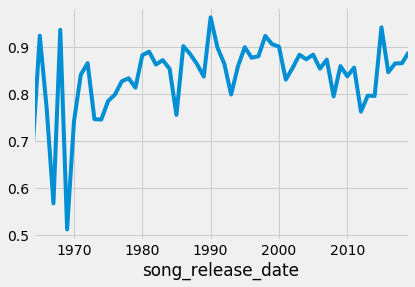

In [15]:
plt.style.use('fivethirtyeight')
df.groupby('song_release_date').energy.mean().plot()

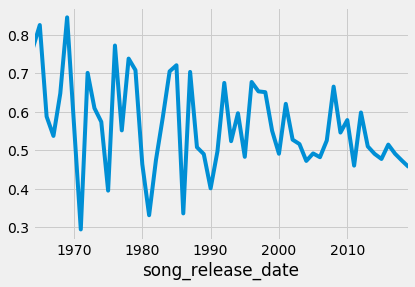

In [16]:
plt.style.use('fivethirtyeight')
df.groupby('song_release_date').valence.mean().plot()

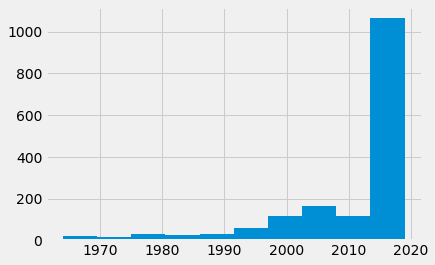

In [17]:
df.song_release_date.hist()

In [2]:
df = pd.read_csv('spotify_punk_playlists.csv')

In [19]:
# df['valence'] = df.valence * 100
# df['danceability'] = df.danceability * 100
# df['energy'] = df.energy * 100
df.dropna(subset=['energy','valence','song_popularity','danceability']).to_csv('spotify_punk_playlists.csv', index=False)

In [5]:
df_features = {}

df_features['decade'] = pd.DataFrame(df.groupby('decade').danceability.mean().reset_index()).decade
df_features['popularity'] = pd.DataFrame(df.groupby('decade').song_popularity.mean().reset_index()).song_popularity
df_features['energy'] = pd.DataFrame(df.groupby('decade').energy.mean().reset_index()).energy
df_features['length'] = pd.DataFrame(df.groupby('decade').duration_ms.mean().reset_index()).duration_ms / 60000
df_features['danceability'] = pd.DataFrame(df.groupby('decade').danceability.mean().reset_index()).danceability
df_features['valence'] = pd.DataFrame(df.groupby('decade').valence.mean().reset_index()).valence
df_features['loudness'] = pd.DataFrame(df.groupby('decade').loudness.mean().reset_index()).loudness
df_features = pd.DataFrame(df_features)

def get_decade(x):
    if x == "'19":
        return 1
    elif x == "'10s":
        return 2
    elif x == "'00s":
        return 3
    elif x == "'90s":
        return 4
    elif x == "'80s":
        return 5
    elif x == "'70s":
        return 6
    elif x == "'60s":
        return 7
    
df_features['order'] = df_features.decade.apply(lambda x: get_decade(x))
df_features = df_features.sort_values('order')

df_features.to_csv('song_features.csv', index=False)

In [6]:
df_features

,decade,popularity,energy,length,danceability,valence,loudness,order
2,'19,30.244868,88.890029,3.229017,44.278974,45.621628,-4.809940,1
1,'10s,31.462687,85.339019,3.406128,45.563539,49.467889,-5.202237,2
0,'00s,35.870229,86.475954,3.432119,44.865267,52.333244,-5.346233,3
6,'90s,30.352459,88.298361,2.868537,41.163934,59.908197,-6.331205,4
5,'80s,40.620000,85.800000,2.538418,42.234000,49.547200,-8.633940,5
4,'70s,31.179487,79.492308,3.690257,44.428205,60.923077,-8.436231,6
3,'60s,31.761905,70.842857,3.162175,50.619048,65.814286,-9.393095,7


In [7]:
df_features.transpose().to_csv('song_features_transposed.csv', index=False)

In [117]:
df_features.to_csv('song_features.csv', index=False)